# Dynamic model

ReviewNB link: https://app.reviewnb.com/orianebro/PhD_Oriane/blob/main/dynamic_model.ipynb

In [1]:
#| echo: false

# Ignore warning about depreciated modules
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
#| echo: false

# Enable interactive plotting
%matplotlib ipympl

## Conceptual diagram

![Conceptual diagram of shoot FSPM (not final version, some errors)](images/shoot_FSPM_conceptual_diagram_alone.jpg "Conceptual diagram")

The main stem grows according to the crop model's plant height.  

The appearance of a leaf is triggered by fixed phyllochron (different for tillers?).  

Cf Fournier et al, 2005 for leaf elongation 

The angle of the leaf with its axis is leaf-age dependent. The leaf blade curvature depends on the angle with the axis and the leaf length.  

The reproductive organs appear from a given thermal time, when the leaves have stopped growing. 

Leaf senescence is constrained by crop model, as it has a direct influence on LAI (green LAI vs. yellow LAI ?).  

The branching pattern is set (Tillers (Zhu et al., 2015)). 

## Time-dependent parametrization of leaf area

$$ \mathcal{A_normalized} = 2 * |\int_{0}^{1} \mathcal{C}(s(u))ds(u)| $$
$$ \mathcal{A} = \mathcal{A_scaled} = 2 * w * |\int_{0}^{L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$
$$ \frac{d\mathcal{A}}{dt} = 2 * w * |\int_{ds(t)/L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$

- $\mathcal{A}$ : final leaf area (or surface), in $cm^2$ (given by crop model)
- $\frac{d\mathcal{A}}{dt}$ : gain in area, in $cm^2$, for a given leaf for a given time step $dt$ (given by crop model)  
- $\mathcal{C}$ : curve of the evolution of the leaf width along the leaf, **from tip to base** (literature/expert knowledge/observation)
- $s(t)$ : curvilinear abscissa of the midrib, in $cm$, as a function of thermal time $t$, such that: $ ds(t) = \sqrt{(dx(t))^2+(dy(t))^2} $ (computed from leaf curvature)
- $w$ : final maximal width of the leaf, in $cm$ (to fix/vary within a reasonable range)
- $L$ : final length of the leaf, in $cm$ (to fix/vary within a reasonable range)
- $t$ : thermal time, in $^oC.day$


The objective is to find, for each growing leaf, at each time step, and for a given leaf area provided to the leaf $\frac{d\mathcal{A}}{dt}$, how much length $ds(t)$ is added to the leaf.

$$ \frac{d\mathcal{A}}{dt} = 2w |\int_{s(t-1)/L}^{s(t)/L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$

According to the Fundamental Theorem of Calculus, $\mathcal{C}$ being at least $C^0$ on $[0,L]$, $F$ being the antiderivative of $\mathcal{C}$, we can write:

$$ \frac{d\mathcal{A}}{dt} = 2w (|F(\frac{s(t)}{L}) - F(\frac{s(t-1)}{L})|) $$

$$ F(\frac{s(t)}{L}) = |\frac{1}{2w} \frac{d\mathcal{A}}{dt} + F(\frac{s(t-1)}{L})| $$

Knowing the other variables, we know have to determine $s(t)$ at thermal time $t$.

In [3]:
#| echo: false
# drawing

## Apparition and growth of phytomers (stem and leaf)

The height of the plant/canopy (here we consider the height of the main stem) is given by the crop model.  
The plastochron (i.e. leaf initiation rate, in $leaf^{-1}$) is the time interval between two successive leaves produced at the SAM.  
The phyllochron (i.e. leaf emergence rate, in $leaf^{-1}$) is the time interval between two successive leaves emerging from the top of the former leaf sheath.  
The time for a leaf to grow is roughly between 1.5 and 2 phyllochrons.  
We consider a linear (rough approximation of beta function) growth for the leaf.  

- $\phi$ : phyllochron, in $^oC.day.leaf^{-1}$ (literature)
- cur_len_int : current length of growing internodes
- fin_len_int : final length of internodes, in $cm$ (literature, bell shaped model too ?)
- height : plant height, in $cm$ (given by crop model)
- $[s(t)]$ : current length of growing leaves, in $cm$ (computed before)
- fin_len_leaf : final length of leaves, in $cm$  (bell shaped model)
- leaf expansion duration, as $x * \phi$, in $^oC.day$ (literature, cf Clerget et al., 2008, etc)  

Cf Fournier et al, 2005; Stewart and Dwyer, 1993; Skinner and Nelson, 1995  



From crop model: 

## Modifying the MTG of a growing plant

There are several ways to conceive the MTG for a growing plant.  

At each thermal time step, the turtle visits each element and adds a value to a time series for each (almost) properties of the MTG.   

**OR**   

At each thermal time step, the MTG is replicated and the growing elements ar modified, and new elements are added if needed.  

In [4]:
## Imports

# from installed packages
import numpy as np
import matplotlib.pyplot as plt
from openalea.plantgl.all import Vector3
from oawidgets.plantgl import *

# from archicrop
from archicrop.cereals_leaf import parametric_leaf
from archicrop.plant_shape import geometric_dist, bell_shaped_dist, compute_leaf_area
from archicrop.plant_design import leaf_azimuth
from archicrop.cereals import build_shoot
from archicrop.display import display_mtg, build_scene, display_scene

# Enable plotting with PlantGL
%gui qt

# Set nice color for plants
nice_green=Color3((50,100,0))

## Code for generating a 3D cereal shoot from descritive parameters
def generate_plant():
    # Parameters 
    height=1000                 # from crop model
    nb_phy=17                   # fixed max nb of phytomers
    max_leaf_length=85.53 
    insertion_angle=40
    scurv=0.7
    curvature=80
    phyllotactic_angle=180
    spiral=False
    
    diam_base=2.5
    diam_top=1.0
    # Lejeune and Bernier formula + col =
    nb_young_phy = int(round((nb_phy - 1.95) / 1.84 / 1.3))
    # stem diameters
    diameter = ([diam_base] * nb_young_phy + np.linspace(diam_base, diam_top, nb_phy - nb_young_phy).tolist()) 
    
    # Functions calls
    insertion_heights=np.array(geometric_dist(height, 
                                              nb_phy, 
                                              q=1.25)) # further separate stem and pseudo stem, cf simple maize
    
    leaf_lengths=np.array(bell_shaped_dist(max_leaf_length=max_leaf_length, 
                                           nb_phy=nb_phy, 
                                           rmax=0.7, 
                                           skew=0.15)) # plant area --> max leaf length
    # leaf_areas=bell_shaped_dist(plant_area=1, nb_phy=15, rmax=0.7, skew=0.15) # cf blade_dimension
    
    a_leaf = parametric_leaf(nb_segment=10, 
                             insertion_angle=insertion_angle, 
                             scurv=scurv, 
                             curvature=curvature, 
                             alpha=-2.3)
    
    leaf_shapes = [a_leaf for l in leaf_lengths] # possible to replace leaf_length by nb_phy or...
    
    leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), 
                                 phyllotactic_angle=phyllotactic_angle, 
                                 phyllotactic_deviation=0, 
                                 plant_orientation=0, 
                                 spiral=spiral)
    
    shoot, g = build_shoot(stem_diameters=diameter, 
                                  insertion_heights=insertion_heights, 
                                  leaf_lengths=leaf_lengths, 
                                  leaf_areas=None, 
                                  leaf_shapes=leaf_shapes, 
                                  leaf_azimuths=leaf_azimuths)
    return g

g = generate_plant()

# Build and display scene
scene, nump = build_scene(g, 
                          leaf_material=Material(nice_green), 
                          stem_material=Material(nice_green))
# display_scene(scene_single) # display in separate window
PlantGL(scene) # display in notebook

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [5]:
from ipywidgets import interact, interactive, IntSlider, fixed
from archicrop.dynamic import grow_plant, grow_plant_and_display

def grow_plant_and_display_in_NB(g, time):
    g, scene, nump=grow_plant_and_display(g, time)
    w=PlantGL(scene, group_by_color=True)
    w.wireframe=True
    return w

# max_time = max(g.property('end_tt').values())
interact(grow_plant_and_display_in_NB, g=fixed(g), time=IntSlider(min=20, max=2000, step=100, value=1000))

interactive(children=(IntSlider(value=1000, description='time', max=2000, min=20, step=100), Output()), _dom_c…

<function __main__.grow_plant_and_display_in_NB(g, time)>

In [6]:
from oawidgets.mtg import plot as MTGw
# MTGw(g, properties='label')
# g.display()

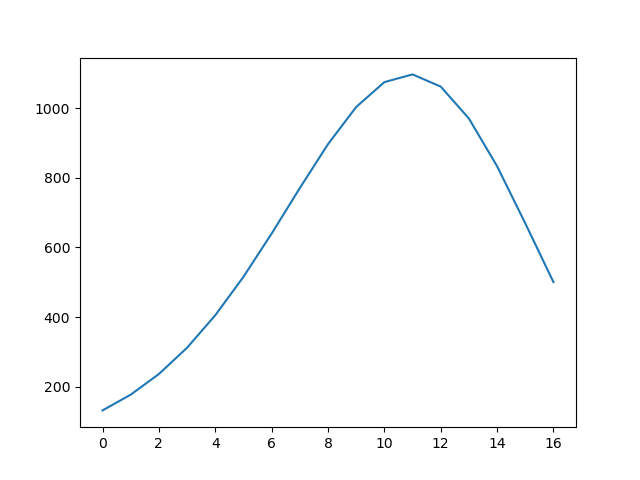

In [7]:
g = generate_plant()

# For loop for generating plants at different stages
for time in [0,84,136,249,385,465,598,672,723,862,942,1025,1148,1295,1363,1472,1538,1618,1702,1899,1988]:
    LAs = compute_leaf_area(grow_plant(g, time=time))

nb_phy=17
plt.clf()
plt.plot(range(0,nb_phy), LAs)
plt.show()

## Fit plant growth and development to LAI(t) and height(t) curves

LAI(t) curve

In [8]:
def linear_LA(x, slope=5, intercept=0.0):
    """
    Generate a linear curve.

    Args:
    - x: Input values
    - slope: Slope of the line
    - intercept: Intercept of the line

    Returns:
    - y: Output values corresponding to the linear curve
    """
    y = slope * x + intercept
    return y

Two constraints :

$$ \mathcal{A} = \mathcal{A_scaled} = 2 w |\int_{L}^{0} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$
where $$\mathcal{C}(x) = \alpha x^2 - 2 (\alpha + \sqrt{-\alpha}) x + 2 \sqrt{-\alpha} + \alpha$$

and
$$ \text{leaf length} = L  e^{-\log(skew) * (2 (z - zmax)^2 + (z - zmax)^3)} $$


20
20
Optimal Parameters: [82.13848277]


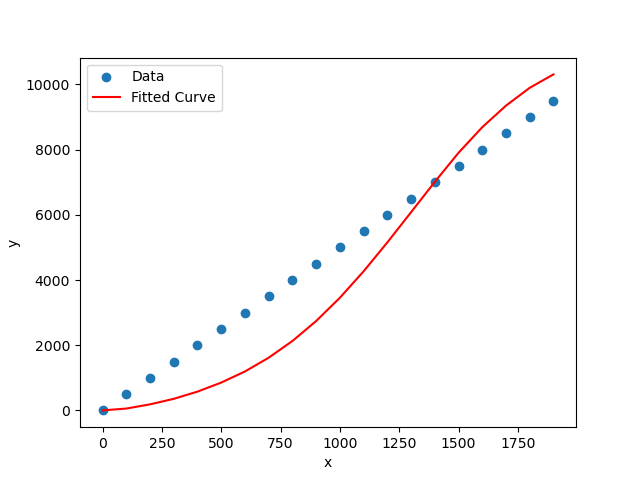

In [10]:
from scipy.optimize import curve_fit

# Define your parametric model as a Python function
def parametric_model(time, max_leaf_length):
    """
    Define your parametric model here.

    Args:
    - x: Input values
    - param1, param2, ...: Parameters of your model

    Returns:
    - y: Output values corresponding to the model
    """
    
    # Compute your model's output based on input values and parameters
    ## Code for generating a 3D cereal shoot from descritive parameters
    # Parameters 
    diam_base=2.5
    diam_top=1.0
    nb_phy=17                   # fixed max nb of phytomers
    # Lejeune and Bernier formula + col =
    nb_young_phy = int(round((nb_phy - 1.95) / 1.84 / 1.3))
    # stem diameters
    diameter = ([diam_base] * nb_young_phy + np.linspace(diam_base, diam_top, nb_phy - nb_young_phy).tolist()) 
    height=1000                 # from crop model
    insertion_angle=40
    scurv=0.7
    curvature=80
    phyllotactic_angle=180
    spiral=False
    
    # Functions calls
    insertion_heights=np.array(geometric_dist(height, 
                                              nb_phy, 
                                              q=1.25)) # further separate stem and pseudo stem, cf simple maize
    
    leaf_lengths=np.array(bell_shaped_dist(max_leaf_length=max_leaf_length, 
                                           nb_phy=nb_phy, 
                                           rmax=0.7, 
                                           skew=0.15)) # plant area --> max leaf length
    # leaf_areas=bell_shaped_dist(plant_area=1, nb_phy=15, rmax=0.7, skew=0.15) # cf blade_dimension
    
    a_leaf = parametric_leaf(nb_segment=10, 
                             insertion_angle=insertion_angle, 
                             scurv=scurv, 
                             curvature=curvature, 
                             alpha=-2.3)
    
    leaf_shapes = [a_leaf for l in leaf_lengths] # possible to replace leaf_length by nb_phy or...
    
    leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), 
                                 phyllotactic_angle=phyllotactic_angle, 
                                 phyllotactic_deviation=0, 
                                 plant_orientation=0, 
                                 spiral=spiral)
    
    shoot, g = build_shoot(stem_diameters=diameter, 
                                  insertion_heights=insertion_heights, 
                                  leaf_lengths=leaf_lengths, 
                                  leaf_areas=None, 
                                  leaf_shapes=leaf_shapes, 
                                  leaf_azimuths=leaf_azimuths)

    y = []
    for t in time:
        y.append(sum(compute_leaf_area(grow_plant(g, time=t))))

    
    # # Build and display scene
    # scene, nump = build_scene(g, 
    #                           leaf_material=Material(nice_green), 
    #                           stem_material=Material(nice_green))
    # # display_scene(scene_single) # display in separate window
    # PlantGL(scene) # display in notebook
    return y

# Prepare your data
x_data = []
y_data = []
for t in range(0,2000,100):
    x_data.append(t)
    y_data.append(linear_LA(t))
x_data = np.array(x_data)  # Your input data
y_data = np.array(y_data)  # Your output data
print(len(x_data))
print(len(y_data))

# Use scipy.optimize.curve_fit to fit your model to the data and obtain optimal parameters
max_leaf_length = 70
initial_guess = [max_leaf_length]  # Initial guess for your parameters
optimal_params, covariance = curve_fit(f=parametric_model, xdata=x_data, ydata=y_data, p0=initial_guess)

# Print the optimal parameters
print("Optimal Parameters:", optimal_params)

# Optionally, visualize the fit
plt.clf()
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, parametric_model(x_data, *optimal_params), color='red', label='Fitted Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Next steps

- Bending dynamics of leaves and tillers